# Weterani

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Poniższy zbiór danych zawiera dane dotyczące kampanii mailingowej mającej zachęcić ludzi do wysłania datków na pewne stowarzyszenie o weteranach. Zmienne, które oznaczają nasz `y` to `TARGET_B` - informacja o tym, czy osoba wysłała datek oraz `TARGET_D` - informacja o tym jaka była wysokość datku. Podczas uczenia będziemy modelować zmienną `TARGET_B` - ale pamiętamy żeby usunąć również zmienną `TARGET_D` z danych ;)  

Głównym problemem w przypadku tego zbioru jest przygotowanie go do uczenia - zbiór zawiera dużą ilość kolumn, ponadto ma bardzo dużo braków danych i zmiennych kategorycznych o wielu poziomach.  

Dokładny opis: https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98dic.txt

In [3]:
data = pd.read_csv("cup98lrn.txt", na_values=[" "], low_memory=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,NaN,NaN,3712,0,NaN,...,0.0,0,L,4,E,X,X,X,39.0,C
1,9401,BOA,1,CA,91326,NaN,NaN,5202,0,NaN,...,0.0,0,L,2,G,X,X,X,1.0,A
2,9001,AMH,1,NC,27017,NaN,NaN,0,0,NaN,...,0.0,1,L,4,E,X,X,X,60.0,C
3,8701,BRY,0,CA,95953,NaN,NaN,2801,0,NaN,...,0.0,1,L,4,E,X,X,X,41.0,C
4,8601,NaN,0,FL,33176,NaN,NaN,2001,0,X,...,0.0,1,L,2,F,X,X,X,26.0,A


In [5]:
data.shape

(95412, 481)

In [6]:
data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [7]:
y = data['TARGET_B']

In [8]:
np.unique(y)

array([0, 1], dtype=int64)

# Zad. 

Robimy StratifiedKFold i znajdujemy optymalne parametry dla

* MultinomialNB (bez redukcji wymiarowości)
* LogisticRegression
* LinearSVC
* SVC
* KNeighborsClassifier
* DecisionTreeClassifier
* RandomForestClassifier
* BaggingClassifier
* ExtraTreesClassifier
* AdaBoostClassifier
* GradientBoostingClassifier
* VotingClassifier
* xgboost.XGBClassifier

Potencjalny plan działania:

*  wyciągnięcie kolumn `TARGET_D`, `TARGET_B` z ramki
*  rozwiązać problem imbalance data
*  Indentyfikacja kolumn o dużej ilości braków danych, oraz decyzja, co z nimi zrobić. Część kolumn można pewnie usunąć, resztą w jakiś sposób imputować. Warto zwrócić uwagę na kolumny, które mają tylko jeden poziom oraz wartość `NaN` - być może `NaN` jest również jakąś informacją.
*  Kolumny kategoryczne - część z nich ma ogromną liczbę poziomów - tutaj też trzeba podjąć jakąś decyzję (albo usunąć całą kolumnę, albo w jakiś sposób sobie z tym radzić). 
*  W tym momencie najprawdopodobniej będziemy mieli mniej kolumn - można zacząć myśleć o budowaniu modelu, ewentualnie poprzedzonego jakąś selekcją cech.
*  Walidacja modelu - sprawdzić, gdzie postawić najbardziej optymalny próg odcięcia. Obliczyć otrzymany zysk.

Najpierw rozwiążmy problem z imbalance data

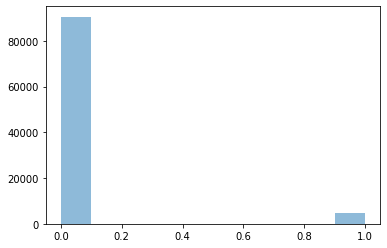

In [11]:
plt.hist(y, alpha=0.5)
plt.show()

In [12]:
X_train = data.values

In [13]:
X_smaller_0 = X_train[y == 0, :]
X_smaller_1 = X_train[y == 1, :]

print(X_smaller_0.shape, X_smaller_1.shape)

indices_0_undersampled = np.random.choice(X_smaller_0.shape[0], size=X_smaller_1.shape[0], replace=False)

X_undersampled_0 = X_smaller_0[indices_0_undersampled]

X_undersampled = np.vstack([X_undersampled_0, X_smaller_1])

y_undersampled = np.array([0]*X_undersampled_0.shape[0] + [1]*X_smaller_1.shape[0]) 

print(X_undersampled.shape, y_undersampled.shape)

(90569, 481) (4843, 481)
(9686, 481) (9686,)


In [36]:
y_undersampled

array([0, 0, 0, ..., 1, 1, 1])

## Spowrotem zapisuje do DataFrame

In [14]:
X_u_df = pd.DataFrame(X_undersampled, columns=data.columns )

# data.dtypes
for x in data.columns:
    X_u_df[x]=data[x].astype(data[x].dtypes.name)

X_u_df.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,NaN,NaN,3712,0,NaN,...,0.0,0,L,4,E,X,X,X,39.0,C
1,9401,BOA,1,CA,91326,NaN,NaN,5202,0,NaN,...,0.0,0,L,2,G,X,X,X,1.0,A
2,9001,AMH,1,NC,27017,NaN,NaN,0,0,NaN,...,0.0,1,L,4,E,X,X,X,60.0,C
3,8701,BRY,0,CA,95953,NaN,NaN,2801,0,NaN,...,0.0,1,L,4,E,X,X,X,41.0,C
4,8601,NaN,0,FL,33176,NaN,NaN,2001,0,X,...,0.0,1,L,2,F,X,X,X,26.0,A


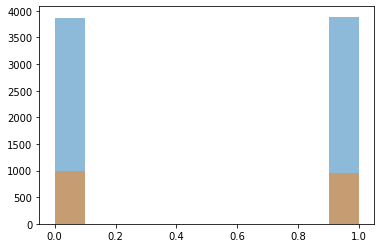

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_u_df, y_undersampled, test_size=0.2, random_state=42)

plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Zbudujmy **pipeline** dla atrybutów numerycznych:

In [39]:
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

# imputer = Imputer(strategy="median")

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(train_data.columns[train_data.dtypes==np.float64])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [40]:
num_pipeline.fit_transform(train_data)

array([[45.        , 84.        ,  1.        , ...,  4.66666667,
         0.        , 57.        ],
       [49.        , 35.        ,  4.        , ..., 20.        ,
         0.        , 43.        ],
       [30.        , 63.        ,  1.        , ..., 13.2       ,
         0.        , 50.        ],
       ...,
       [18.        , 62.        ,  1.        , ..., 12.25      ,
         0.        , 46.        ],
       [45.        , 62.        ,  1.        , ...,  9.        ,
         0.        , 59.        ],
       [12.        , 62.        ,  1.        , ..., 22.66666667,
         0.        , 20.        ]])

Będziemy także potrzebować imputera do kategorycznych kolumn  napisowych (zwykły Imputer nie działa na tych kolumnach):

In [41]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Teraz możemy zbudować **pipeline** dla atrybutów kategorycznych:

In [42]:
from sklearn.base import TransformerMixin
from sklearn.utils import murmurhash3_32
class HashCategorical(TransformerMixin):
    
    def __init__(self, k=10):
        self.k = k
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #na każdej obserwacji w X zastosować funkcję murmurhash3_32
        X_transformed = X.applymap(lambda x: murmurhash3_32(str(x)) % self.k)
        return X_transformed 

In [43]:
import sklearn
print(sklearn.__version__)

# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

0.21.2


In [44]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(['OSOURCE', 'STATE', 'ZIP', 'MDMAUD', 'DOMAIN', 'GENDER',
       'RFA_2', 'RFA_3', 'RFA_4', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_11',
       'RFA_12', 'RFA_14', 'RFA_2R', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F',
       'MDMAUD_A', 'GEOCODE2'])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ])

In [46]:
cat_pipeline.fit_transform(X_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]])

Na koniec połączmy powyższe podejścia:

In [47]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [48]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed)

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

pipe = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', LinearSVC(C=1))])

param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

{'classifier__C': 0.01}

In [ ]:
from sklearn.svm import SVC

pipe_2 = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', SVC(C=1))])

param_grid_2 = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
            'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(train_data, y_train)
grid_2.best_params_

In [51]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true= y_train, y_pred = grid_1.best_estimator_.predict(X_train))

array([[3858,    0],
       [3890,    0]], dtype=int64)

In [52]:
confusion_matrix(y_true= y_test, y_pred = grid_1.best_estimator_.predict(X_test))

array([[985,   0],
       [953,   0]], dtype=int64)

In [33]:
from sklearn import  metrics

models = []
models.append(('SVM linear', grid_1.best_estimator_))


precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test , model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test , model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test , model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))

SVM linear
precision_score: 0.4917440660474716
recall_score: 1.0
f1_score: 0.6592874437910757
accuracy_score: 0.4917440660474716


In [34]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM linear'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,SVM linear,0.491744,1.0,0.659287,0.491744
